# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [92]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [93]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions

    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    return [token for token in tokens if token.lower() not in sw]
    #return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    

    return whitespace_pattern.split(text.strip())
    #return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

Read in twitter first

In [65]:

twitter_folder =  r"M1 Assignment Data\M1 Results\twitter"
artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

cher_path = os.path.join(twitter_folder, artist_files['cher'])

twitter_data = pd.read_csv(cher_path, sep="\t", quoting=3)
twitter_data['artist'] = "cher"

In [66]:

robyn_path = os.path.join(twitter_folder, artist_files['robyn'])

twitter_data_2 = pd.read_csv(robyn_path, sep="\t", quoting=3)
twitter_data_2['artist'] = "robyn"


twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

Read in lyrics

In [68]:

lyrics_data = defaultdict(dict)
for artist in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist)
    if os.path.isdir(artist_path):
        for song_file in os.listdir(artist_path):
            if song_file.endswith(".txt"):
                song_path = os.path.join(artist_path, song_file)
                with open(song_path, 'r', encoding='utf-8') as f:
                    lyrics_data[artist][song_file] = f.read()

rows = []
for artist, songs in lyrics_data.items():
    for song_file, lyrics in songs.items():
        rows.append({
            "artist": artist,
            "song": song_file,
            "lyrics": lyrics
        })

# Create the DataFrame
lyrics_df = pd.DataFrame(rows)
#removing the first line from the lyrics column, gpt helped me with this
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: '\n'.join(x.split('\n')[1:]))

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [99]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]


twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


lyrics_df["tokens"] = lyrics_df["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len) 

twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [95]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
781862,cher,✨overcaffeinated early modernist and art museu...,"[✨overcaffeinated, early, modernist, art, muse..."
1588354,cher,🦋 ✨ ✊🏽 ♊️,"[🦋, ✨, ✊🏽, ♊️]"
13586,robyn,Suelo perderme en mi mente🌌🏕 #Matelover 🌿🧉#cat...,"[suelo, perderme, en, mi, mente🌌🏕, #matelover,..."
2356224,cher,"Most heros were capes,mine wears a guitar⭕️","[heros, capesmine, wears, guitar⭕️]"
576399,cher,Taurus 🌞 Libra 💫 Capricorn 🌚,"[taurus, 🌞, libra, 💫, capricorn, 🌚]"
3905,cher,"BLM, 🌈, liberal, be kind","[blm, 🌈, liberal, kind]"
2389365,cher,✯☾✯ Sales Distribution Consultant ✯☽✯ https://...,"[✯☾✯, sales, distribution, consultant, ✯☽✯, ht..."
38334,robyn,"✨ La solitude, c’est parfait ✨","[✨, la, solitude, c’est, parfait, ✨]"
221733,cher,"Scorpio ☼, Taurus ☾, Capricorn ↥ #Slytherinpri...","[scorpio, ☼, taurus, ☾, capricorn, ↥, #slyther..."
698563,cher,"Proud Mother, Animal lover, #catrescuer, fight...","[proud, mother, animal, lover, #catrescuer, fi..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Something that I noticed in subsequent steps were that common stopwords with typos weren't removed. For example "I'm" I believe is a stopword, but Im was left, we'd need to account for the common typos/abbreviations to have more effective stopwords.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [97]:
def descriptive_stats(text, verbose=True):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and 5 most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """

    num_tokens = len(text)
    num_unique_tokens = len(set(text))
    num_characters = sum(len(word) for word in text)
    
    if num_tokens > 0:
        lexical_diversity = num_unique_tokens / num_tokens
    else:
        lexical_diversity = 0.0

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        token_counts = Counter(text)
        most_common = token_counts.most_common(5)
        print("The 5 most common tokens are:")
        for token, count in most_common:
            print(f"{token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

First flatten lyrics

In [74]:
cher_tokens = []
for tokens in lyrics_df[lyrics_df['artist'] == 'cher']['tokens']:
    cher_tokens.extend(tokens)


robyn_tokens = []
for tokens in lyrics_df[lyrics_df['artist'] == 'robyn']['tokens']:
    robyn_tokens.extend(tokens)

# Example usage


In [75]:
lyrics_df['tokens'][0][4]

'friends'

In [76]:
descriptive_stats(cher_tokens)


There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
The 5 most common tokens are:
love: 966
im: 511
know: 480
dont: 430
youre: 332


[35233, 3684, 0.10456106491073709, 169244]

In [77]:
descriptive_stats(robyn_tokens)

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
The 5 most common tokens are:
know: 305
im: 299
dont: 297
love: 269
got: 249


[15041, 2139, 0.1422112891430091, 72804]

Q: what observations do you make about these data? 

A: Robyn has more leixcal diversity despite having less total lyrics, not what I would have assumed based on the few songs I've heard from her, and the nature of songs where artists usually make different songs about different things over time which I'd expect to *increase* lexical diversity for cher


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [98]:
cher_counter = Counter(cher_tokens)
robyn_counter = Counter(robyn_tokens)
cher_total = sum(cher_counter.values())
robyn_total = sum(robyn_counter.values())


min_count = 5


cher_ratios = {}

for token in cher_counter:
    if cher_counter[token] >= min_count and robyn_counter[token] >= min_count:
        cher_conc = cher_counter[token] / cher_total
        robyn_conc = robyn_counter[token] / robyn_total
        if robyn_conc > 0:
            cher_ratios[token] = cher_conc / robyn_conc

# gpt helped me with dictionary sorting
cher_sorted = sorted(cher_ratios.items(), key=lambda item: item[1], reverse=True)

cher_top10 = cher_sorted[:10]


robyn_ratios = {}

for token in robyn_counter:
    if robyn_counter[token] >= min_count and cher_counter[token] >= min_count:
        robyn_conc = robyn_counter[token] / robyn_total
        cher_conc = cher_counter[token] / cher_total
        if cher_conc > 0:
            robyn_ratios[token] = robyn_conc / cher_conc


robyn_sorted = sorted(robyn_ratios.items(), key=lambda item: item[1], reverse=True)

robyn_top10 = robyn_sorted[:10]

# Step 6: Output
print("Top 10 distinctive tokens for Cher:")
for token, score in cher_top10:
    print(f"{token}: {score:.2f}")

print("\nTop 10 distinctive tokens for Robyn:")
for token, score in robyn_top10:
    print(f"{token}: {score:.2f}")


Top 10 distinctive tokens for Cher:
walk: 9.73
find: 9.61
enough: 7.56
without: 7.17
man: 7.15
strong: 6.49
live: 5.81
believe: 5.39
tears: 4.78
well: 4.35

Top 10 distinctive tokens for Robyn:
beat: 19.84
dance: 13.87
work: 11.71
hang: 10.25
shake: 7.03
alright: 7.03
forgive: 7.03
party: 6.15
88: 6.09
space: 5.86


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Robyn has some very dance specific top tokens which make sense for her as a dance artist, chers top tokens are more generic 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [81]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

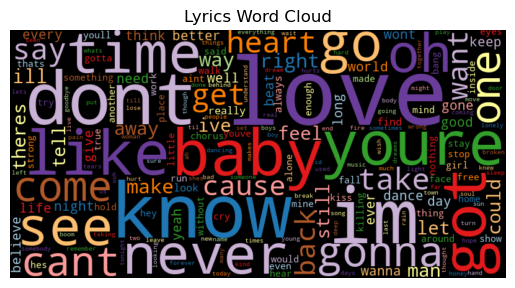

In [89]:
word_freq_df = count_words(lyrics_df, column="tokens", min_freq=5)
wordcloud(word_freq_df['freq'], title="Lyrics Word Cloud")


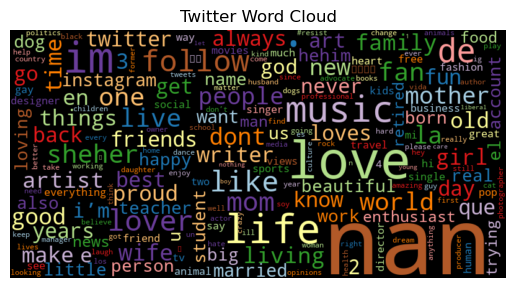

In [90]:
twitter_freq = count_words(twitter_data, column="tokens", min_freq=5)

# Generate the word cloud
wordcloud(twitter_freq['freq'], title="Twitter Word Cloud")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The twitter word clouds features more references to social media (twitter, instagram) than the lyrics do. I wonder if we chose more contemporary artists if they would show up there. Also the lyrics word clouds have several words which are super common, like baby which is commonly used in songs but less so in everyday conversation 